
# Project: Identification of Fake Currency Notes

## Introduction
In this project, we employ several supervised machine learning algorithms to build models that distinguish between genuine and counterfeit banknotes. We will analyze these algorithms to choose the best candidate, and then try to further optimize the algorithm to best model the data. Our goal with this implementation is to accurately predict whether a currency note is genuine or fake. This sort of analysis is needed, since every major economy is flooded with counterfeit notes. 


## Exploring the data
We load here the necessary Python libraries and load the banknote authentication dataset. The last column of this dataset 'class' is our target variable. All other columns are features about each currency note in the dataset. The target column is a binary valued variable, with value 1 meaning the note is genuine, and value 0 meaning the note is counterfeit. 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

#Import supplementary visualization code visuals.py
import visuals as vs

# Display all visuals inline
%matplotlib inline

# Load the Banknote Authentication dataset
data = pd.read_csv(r"C:\Users\Arjun\Downloads\fake currency prediction.csv")
display(data.head(n=6))

classes = data['Target']
features = data.drop('Target', axis=1)

,variance,skewness,curtosis,entropy,Target
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0
5,4.36840,9.6718,-3.9606,-3.16250,0


In [5]:
# autoreload for automatically reloading changes made in visuals.py
%load_ext autoreload
%autoreload 2

----
## Exploratory Data Analysis
Now, we will do some data exploration to find out the number of samples belonging to each of the two classes, that is, how many samples belong to fake notes and how many belong to genuine notes. We will also determine if the dataset contains any missing values.

In [6]:
n_records = len(data)
n_fake_notes = len(data[data['Target'] == 0])
n_real_notes = len(data[data['Target'] == 1])
print("Total number of records: {}".format(n_records))
print("Total number of fake notes: {}".format(n_fake_notes))
print("Total number of real notes: {}".format(n_real_notes))

missing_values = data.isnull().sum().sum()
if missing_values == 0:
    print("\nThere are no missing values in the dataset")
else:
    print("\nThe dataset has {} missing values".format(missing_values))

Total number of records: 1372
Total number of fake notes: 762
Total number of real notes: 610

There are no missing values in the dataset


### Statistical Analysis of Features
In the code cell below, we statistically describle various features of the dataset, including mean, standard deviation, median, minimum and maximum values. We observe that the features have different range of values, and would like to scale them in the reange of 0-1.

In [7]:
display(data.describe())

,variance,skewness,curtosis,entropy,Target
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


### Looking for Skewedness in Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. We plot distributions of all continuous features to find if any skewedness is present in any of the features. We observe that all features are well distributed and do not have any such outlier values.

C:\Users\Arjun\fake currency\visuals.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


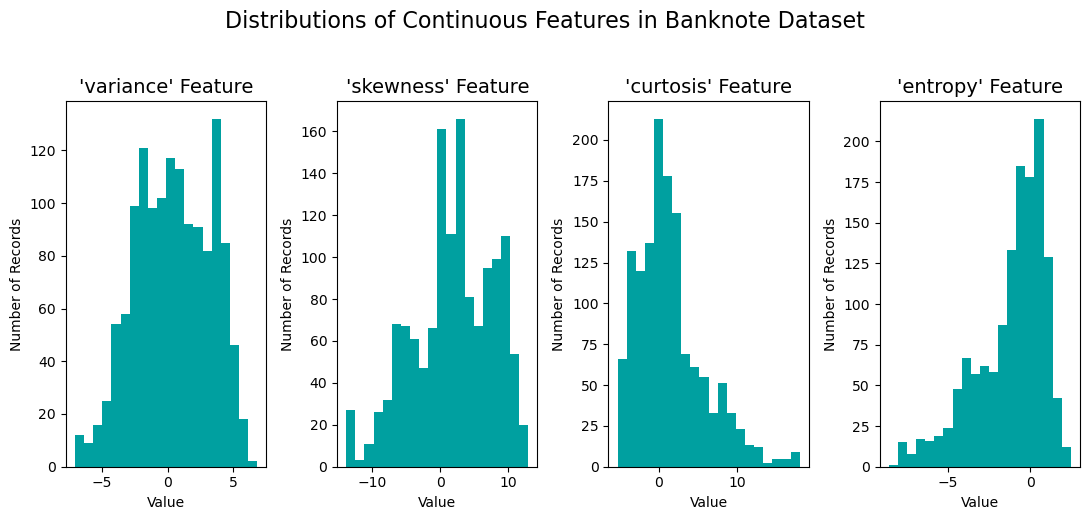

In [8]:
# feature plotting
vs.distribution(data)

### Identifying Predictive Power of Features
We create six classification scatter plots (using 2 of the 4 numerical attributes for each display), and use different colors for objects belonging to class 1 and class 0. This will give us an idea about which pair of features classify the dataset more strongly.

C:\Users\Arjun\fake currency\visuals.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


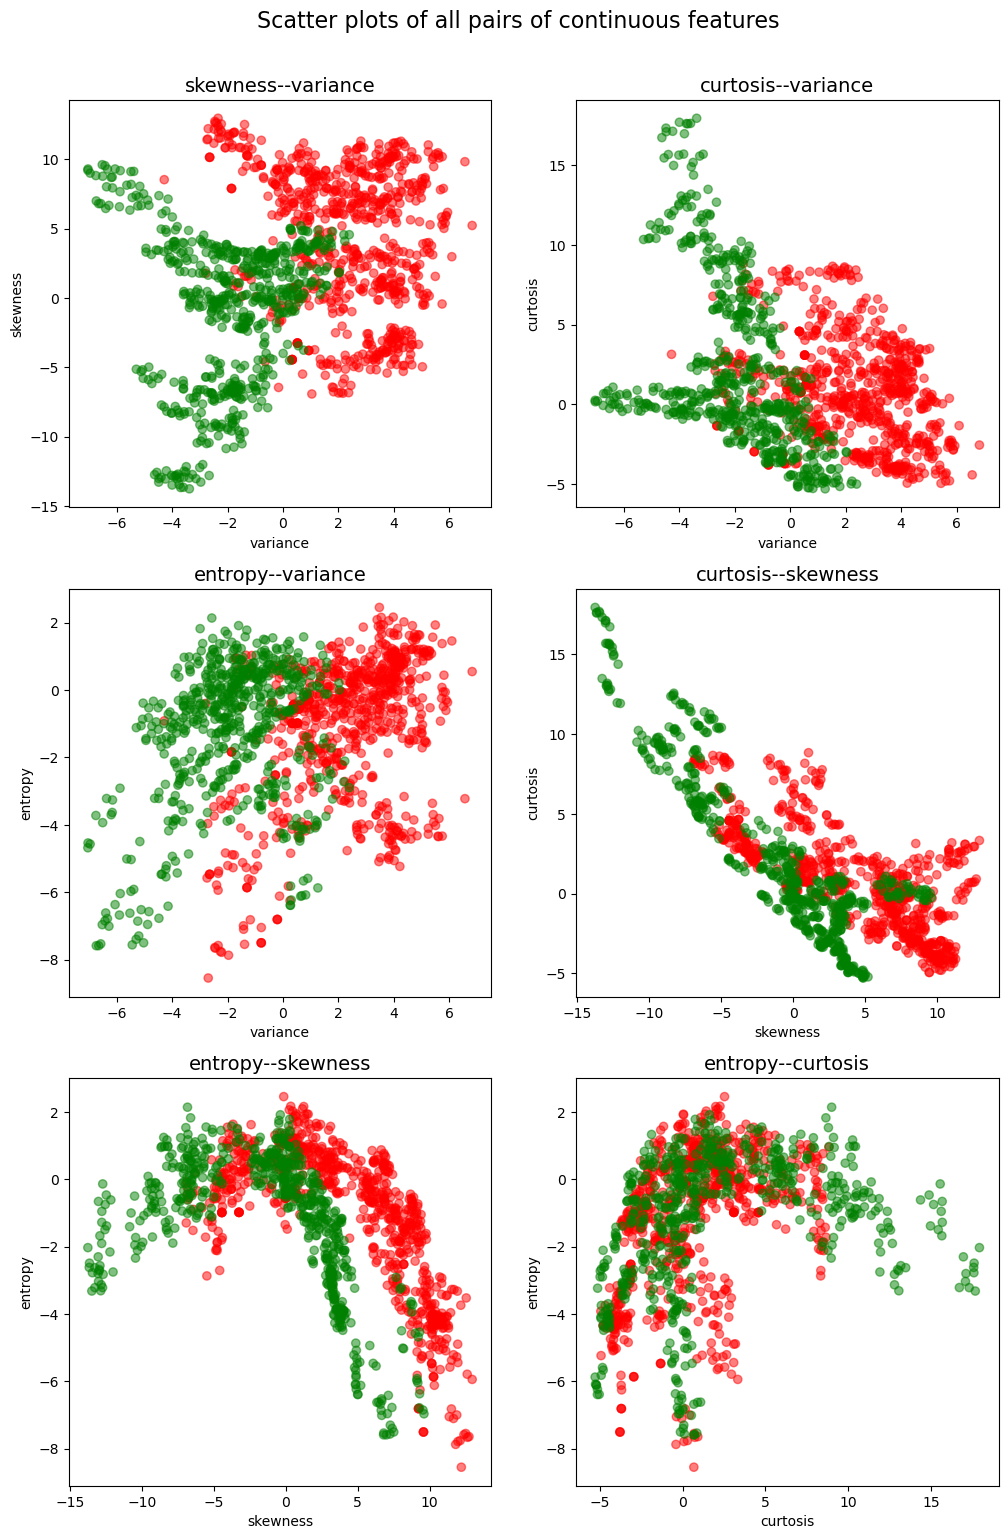

In [9]:
vs.scatter(data)

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as preprocessing. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Normalizing Numerical Features
 In this section, we want to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as 'variance' or 'skewedness' above); however, normalization ensures that each feature is treated equally when applying supervised learners. 

In [10]:
from sklearn.preprocessing import MinMaxScaler
numerical = ['variance', 'skewness', 'curtosis', 'entropy']
scaler = MinMaxScaler()
features[numerical] = scaler.fit_transform(features[numerical])

display(features.head(n = 6))


,variance,skewness,curtosis,entropy
0,0.769004,0.839643,0.106783,0.736628
1,0.835659,0.820982,0.121804,0.644326
2,0.786629,0.416648,0.310608,0.786951
3,0.757105,0.871699,0.054921,0.450440
4,0.531578,0.348662,0.424662,0.687362
5,0.822859,0.877275,0.057100,0.489711


### Shuffle and Split Data
Now that all numerical features have been normalized, we will now split the data (both features and their labels) into training and test sets. 60% of the data will be used for training and 40% for testing.

In [105]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'classes' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, classes, test_size = 0.4, random_state = 5)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 823 samples.
Testing set has 549 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners, and the fourth algorithm is known as a naive predictor, which is our benchmark model.

### Metrics and the Naive Predictor
We also require to define evaluation metrics that we can use to quantify the performance of our solution, as well as, the benchmark model. The metrics that we will use for our problem are accuracy and f-score. Accuracy is defined as the number of samples correctly classified to the total number of samples. This can be a good metric, but suppose, if it’s more detrimental for us if are not able to correctly classify a fake note, than a real one. Therefore, the model’s ability to recall all fake currency notes is more important than the model’s ability to make precise prediction. In this scenario, we can use, Fβ score with β = 2, as it weighs recall more than precision. The general form is: 
$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

We will compare the performance of our model with a naïve classifier, which classifies all banknotes as fake. The accuracy of this naïve classifier will be number of fake banknotes to the total number of notes in the data. Our model should perform far better than the naïve approach to be any worthy for intended use. Since, this naïve prediction model does not consider any information to substantiate its claim, it helps establish a benchmark for whether a model is performing well. That been said, using a naïve prediction would be pointless as will predict all notes counterfeit and would not identify any note as genuine.

In the code cell below, we calculate the evaluation metrics for the Naive Predictor benchmark model.

In [106]:
# Calculate Accuracy
accuracy = float(n_fake_notes)/n_records

# Calculate F-Score with beta = 2
precision = accuracy
recall = 1
beta = 2
fscore = (1 + beta ** 2) * precision * recall /(beta ** 2 * precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.5554, F-score: 0.8620]


### Supervised Learning Models
We have chosen the following supervised learning models to build the trained models:
- Support Vector Machines (SVM)
- Gradient Boosting, an ensemble method
- K-Nearest Neighbors (KNeighbors)

### Implementation: Create Training and Prediction Pipeline
To properly evaluate the performance of each model you've chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

In [113]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    beta=2
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set,
    # then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300] ,predictions_train, beta)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test,beta)
    
    # Compute Confusion Matrix
    results['conf_mat'] = confusion_matrix(y_test, predictions_test)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Initial Model Evaluation
In the code cell, we implement the following:
- Import the three supervised learning models that we have chosen.
- Initialize the three models and store them in 'clf_A', 'clf_B', and 'clf_C'.
- Calculate the number of records equal to 5%, 20%, and 100% of the training data.
- Store those values in 'samples_5', 'samples_20', and 'samples_100' respectively.

In [114]:
# Import the three supervised learning models from sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from math import ceil
from time import time

# Initialize the three models
clf_A = KNeighborsClassifier(n_neighbors = 5)
clf_B = SVC(random_state = 5)
clf_C = GradientBoostingClassifier(random_state = 5)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_5 = int(X_train.shape[0] * 0.05)
samples_20 = int(X_train.shape[0] * 0.2)
samples_100 = X_train.shape[0]

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_5, samples_20, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

print("\nTrain-Test Scores when trained on entire training set")
for key, value in results.iteritems():
    print("For {} Classifier, scores on training and test set are:".format(key))
    print("Accuracy on Train set: {}".format(value[2]['acc_train']))
    print("Accuracy on Test set: {}".format(value[2]['acc_test']))
    print("F-score on Train set: {}".format(value[2]['f_train']))
    print("F-score on Test set: {}".format(value[2]['f_test']))
    print("Confusion Matrix for test set:\n {}".format(value[2]['conf_mat']))
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

TypeError: check_array() missing 1 required keyword-only argument: 'input_name'

----
## Improving Results
In this final section, we choose from the three supervised learning models the *best* model to use. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

We choose KNN-Classifier as the best model, and try to fine-tune its parameters to improvise on our results. But we see that the model is already performing optimally, and there is no visible improvement.

We also output the best set of parameters that the model has identified.

### Model Tuning
We fine-tune the chosen model. We use grid search (GridSearchCV) with at least one important parameter. We will need to use the entire training set for this.

In [109]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import StratifiedShuffleSplit

# Initialize the classifier
clf = KNeighborsClassifier()

# Create the parameters list you wish to tune
parameters = {'n_neighbors':[1,2,3,4,5,6], 'weights':['uniform','distance'], 'algorithm':['ball_tree','kd_tree']}

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedShuffleSplit(y_train, test_size=0.4, random_state=5) 

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring = scorer, cv = cv)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 2)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 2)))
print("\n------")
print("Following are the parameters for the optimized model")
print(grid_fit.best_params_)

TypeError: 'Series' object cannot be interpreted as an integer

### Choosing best value for nearest neighbors
Since, the grid search returns best value of number of nearest neighbors parameter as 1, we would like to separately iterate over number of neighbors to find the best value of ‘n_neighbors’. We do this to find how the accuracy and f-scores vary with increasing value of ‘n_neighbors’.

When we do this, we see that accuracy and f-scores are same for all values of n_neighbors upto 10. This is further indication of the robustness of our model.

In [110]:
acc_scores = []
fbeta_scores = []
k_range = range(1,16)
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    acc_scores.append(accuracy_score(y_test,y_pred))
    fbeta_scores.append(fbeta_score(y_test, y_pred, beta=2))

TypeError: check_array() missing 1 required keyword-only argument: 'input_name'

In [111]:
for i in range(len(acc_scores)):
    print("{}: Accuracy is {}, f-score is {}".format(i+1,acc_scores[i], fbeta_scores[i]))

### Feature Importance
In this section, we would like to quantify the relative predictive power of each feature with respect to a given classifier. We choose two algorithms here, viz., Random Forests and Gradient Boosting, and determine the importance of each of the features.

We see that first three features play a major role in predicting class labels, while entropy has the least predictive power.

In [112]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(random_state = 5)
# Train the supervised model on the training set 
model = clf.fit(X_train, y_train)

# Extract the feature importances
importances = model.feature_importances_

print("Feature Importances with regard to Random Forest Classifier:")
print(importances)
print("Feature Importances with regard to Gradient Boosting Classifier:")
print(clf_C.feature_importances_)

Feature Importances with regard to Random Forest Classifier:
[0.24 0.28 0.4  0.08]
Feature Importances with regard to Gradient Boosting Classifier:


NotFittedError: This GradientBoostingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.